# Lab 1 - Analyzing factors influencing salary for job postings
Group-2: Alexandra Fisher, Ben Fowler, James Hancock & Shweta Viswanath
MSDS 7331 Sec 401 Data Mining

# Purpose of choosing this dataset
We have chosen this dataset of around a million records from the Job website "Indeed". Indeed is in  a very competitive professional networking and market place business with millions of job postings from all over the country with insights to the job posting details, salary range per company and the job seeker information.

Today most employers are providing similar information to attract talent through multiple platforms. One of the key challenge for Indeed is to drive competitive advantage for its platform by providing comprehensive and insightful information in an intuituve way to its users. The market in the context of salary traditionally has been limited to the average salary for a given company, location and title. However, it is common knowledge that professionals with the same title and company have different salaries. With so many different dimensions( industry, education background, years of experience, expertise, etc.) predicting a customized salary per the seeker's background is a challenge. With the data points from Indeed, we also know that most employers do not provide a salary range for most of the postings. 

The goal of this exercise (lab1) is to analyze the factors influencing salary using logistic regression techniques and develop a best-fit model to predict the approximate salary for job seekers based on their individual profiles. 

The overall key objective is to learn from large data sets around careers and salaries to help the job seeker make the best career decisions. We wish to achieve this by using data mining techniques like classification and machine learning to classify job profiles and build a good prediction algorithm to predict and forecast customized salary  with high accuracy based on users profile so that job seekers can take informed decisions to advance their career.  


In [1]:
# We begin by importing the various libraries for pandas, numpy, scikit-learn, seaborn and 
# matplotlib

#Import 
import pandas as pd
import numpy as np
import glob
from matplotlib.colors import ListedColormap
from pandas.tools.plotting import scatter_plot
from sklearn import datasets as ds
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.lda import LDA

import seaborn as sns
cmap = sns.diverging_palette(200,10, as_cmap=True)

# Import matplot lib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# To read the files from the specified folder, here the data folder 
#glob(/train_*.csv')

C:\Users\Ben Fowler\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


# Data Preparation :

The data from Indeed was stored in 2 CSV files of a million rows each - the train_features.csv file consisted of all the job and seeker details, while the salary train_salary.csv consisted of only the salary information. We use the below set of code to merge the 2 files into one dataframe

In [2]:
# Loading the train_features dataset into features variable
features = pd.read_csv('/train_features_2013-03-07.csv')
features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [3]:
# Loading the train_salaries dataset into salaries variable
salaries = pd.read_csv('/train_salaries_2013-03-07.csv')
salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [4]:
# Merging the features and salaries together so that we have a complete data set
df = pd.merge(features, salaries, how='left')
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


# Data Quality

Though there are no missing values in the dataset, there are some key attributes with 0 value and we examine those in greater detail -

1) 0.0005% of the Salary data has 0 values (5 out of a million entries) We decide to delete these 5 entries as this is a very insignificant volume compared to total no of entries

2) There are 53.23% entries with major as "None", 23.68% of degree as "None" - These are valid datapoints as there are cases of individuals with no majors or degrees with jobs. We decide to leave them as is for analysis

There are no outliers in this data set. (Show Scatter plot matrix)

Please note: This is a "mock" dataset provided by Indeed, hence this is missing some important attributes like company name, location / city, Skills

The scatter plot matrix above shows the relationship of three attributes to each other.
From this it can be seen that Years of experience and proximity to metropolis are directly correlated to salary. However there appears to be absolutely no correlation between years of experience and miles from metropolis. There is also no evidence of outliers

In [5]:
# Data Manipulations

# Remove jobID and CompanyID
if 'jobId' in df:
    del df['jobId']    
if 'companyId'in df:
    del df['companyId']
    
# Remove the 5 entries with salary = 0
df = df[df.salary != 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 7 columns):
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(4)
memory usage: 61.0+ MB


We next create a new variable "salTrue" based on the Mean of the Salary. If the salary is > than Salary Mean, salTrue is True else it get the value False. This is in preparation for PCA and Logistic Regression

In [6]:
salMean = df.salary.mean()
print salMean

df['salTrue']=df.salary>salMean
df.info()
df.head()

116.062398312
<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 8 columns):
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
salTrue                999995 non-null bool
dtypes: bool(1), int64(3), object(4)
memory usage: 62.0+ MB


,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salTrue
0,CFO,MASTERS,MATH,HEALTH,10,83,130,True
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,False
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,True
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,True
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,True


# Data Description & Manipulation


In [7]:
df.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


The above table shows the range, mean and counts of the continuous variables Years, miles and salary. The SalTrue variable is showing that the values with a salary higher than the mean of the data set is .4722% of the total salary of the data set as a whole.

We next create dummy variables using one hot encoding for the categorical attributes - Job Type, Degree, Major and Industry to show the intricate relationships between the various categories.

In [8]:
# Create function to change column order moving salary to the first integer attribute. This is needed for subsequent PCA analysis. 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]
df = change_column_order(df, 'salary', 2)

In [9]:
# Create function to change column order moving salary to the first integer attribute. This is needed for subsequent PCA analysis. 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]
df = change_column_order(df, 'salTrue', 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 8 columns):
jobType                999995 non-null object
degree                 999995 non-null object
salary                 999995 non-null int64
salTrue                999995 non-null bool
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
dtypes: bool(1), int64(3), object(4)
memory usage: 62.0+ MB


# Simple Statistics - (single Attributes)

The below histogram detailing the frequency of salaries shows a fairly normal data distribution. The median is around 100K to 130K. The despiction would lead one to beleve that the values for salary are normally distributed across the data set allowing us to perform a bevie of statistical analysis tests on the data set with minimal transformation.

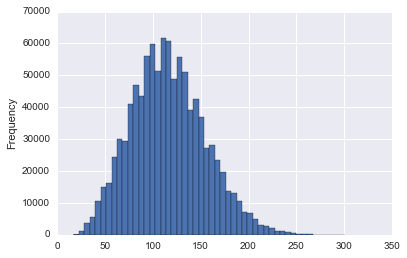

In [11]:
# Histogram of salaries 
dfs = df.salary
dfs.plot.hist(by='salary',bins=50)
#DataFrame.plot.hist(by=None, bins=10, **kwds)

Below is a violin plot that shows the various salaries and distrubution. From this we can see that a majority of people are making in the low 100k range.

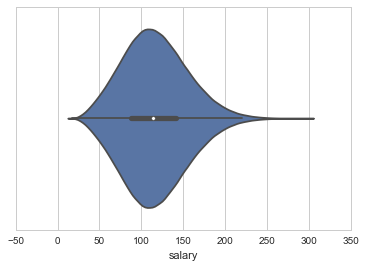

In [12]:
# Violin Plot
sns.set_style("whitegrid")
ax = sns.violinplot(x=df["salary"])

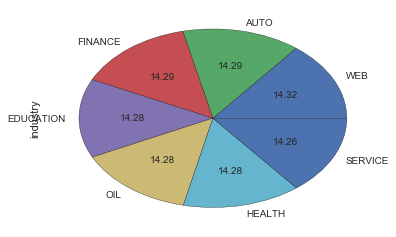

In [13]:
# Pie Chart - By Industry
df.industry.value_counts().plot(kind='pie', autopct='%.2f')

The job postings are equally distributed (around 14.29% each) amongst the Industries. Showing that there are virtually an even number of data points for each industry.

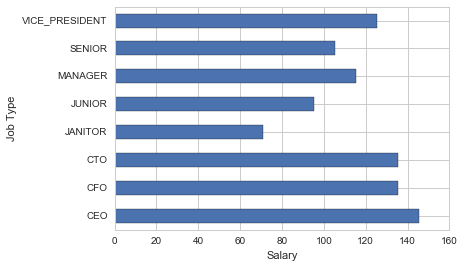

In [14]:
# Bar graph - Average Salary per Job Type
df_cjob = df.groupby(by=df.jobType).mean()
jobSal = df_cjob.salary
ax = jobSal.plot(kind='barh')
ax.set_xlabel("Salary")
ax.set_ylabel("Job Type")

The above bar graph shows the salary distribution per Job Title showing that the salary average for the Executive jobs (CEO, CFO, CTO, VPs) are in the same range (120K-140K). The average salary for Sr, Jr and managers are in the range of 90K - 115K.

The below graph shows the Salary range (max - min) amongst the positions by Job Type. The range of all positions (except Janitor) is in the similar range. 


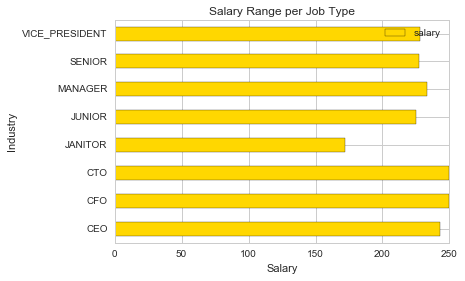

In [15]:
# Range of salary by JobType - SV - Need to check if this is ok
df_jobType = df.groupby('jobType')

minSal = df_jobType.salary.min()
#print minSal
maxSal = df_jobType.salary.max()
#print maxSal
salRange = maxSal - minSal
#print salRange

# Plot as stacked bar chart
salRange.plot(kind='barh',
             stacked=True,
             title='Salary Range per Job Type',
               color=['gold']
             )

plt.xlabel('Salary')
plt.ylabel('Industry')
plt.legend(loc='upper right')

In the graph below it is shown what the correlation between years experince and salary is for each year of experience. This graph is incredibly helpful in determining what one should make based on years experience, and when they would be getting a great offer or a bad one. 

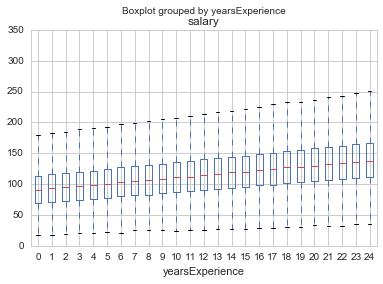

In [16]:
# Boxplots of  Grouped by jobType, YearsExp
df.boxplot(column='salary', by = 'yearsExperience')

The plot below was deemed necessary for the data set was to perform a box plot of salary in relation to degree achieved. As expected the highed degree achieved the higher the salary, with the exception of a doctoral degree, and masters degree being very similar in peak. Most likely a determinant of the fact that salaries in education are lower as a whole.

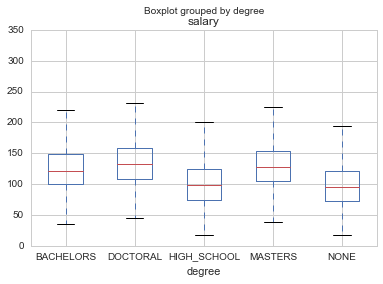

In [17]:
#Lets do Boxplots of  Grouped by Job Type
df.boxplot(column='salary', by = 'degree')

# Data Visualization and Attribute Relationships


In [18]:
# We run the below scatter plot matrix to check the outliers and non-colinearity among the variables
from pandas.tools.plotting import scatter_matrix

ax1 = scatter_matrix(df, figsize=(15,10), diagonal='kde')

The scatter plot matrix above shows the relationship of three attributes to each other. From this it can be seen that Years of experience and proximity to metropolis are directly correlated to salary. However there appears to be absolutely no correlation between years of experience and miles from metropolis. There is also no evidence of outliers

In [19]:
# Import matplot lib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [20]:
import seaborn as sns
cmap = sns.diverging_palette(220,10, as_cmap=True)

In [ ]:
#Axis Grid
sns.diverging_palette(145, 280, s=85, l=25, n=7)
sns.pairplot(df, hue='jobType', size=2, palette="husl", kind='reg')

The above Pair Grid shows the relationship between Salary, Years of Experience and Miles From Metropolis and Job Type. The linear regression lines show that a Janitor will have a greater growth in salary as years of experience increases than any other job type. Also, as miles from metropolis increases, salary declines for a Janitor at a greater declining rate than any other job type. 

Due to the fact that it is planned to perform a Logistic Regression on the data set, "dummy" variables were created in order to help perform find possible values to project and fill.

In [ ]:
df = pd.get_dummies(df, columns=['jobType', 'degree', 'major', 'industry'])

In [ ]:
#Create a list of Categorical Variables

cSuiteJobs = ['jobType_CEO', 'jobType_CFO', 'jobType_CTO'];
jobTypes = ['jobType_CEO', 'jobType_CFO', 'jobType_CTO', 'jobType_JANITOR','jobType_JUNIOR','jobType_MANAGER','jobType_SENIOR', 'jobType_VICE_PRESIDENT'];
college = ['degree_BACHELORS', 'degree_DOCTORAL', 'degree_MASTERS'];
high_School_or_More = ['degree_HIGH_SCHOOL','degree_BACHELORS', 'degree_DOCTORAL', 'degree_MASTERS'];
majors = ['major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING', 'major_MATH', 'major_PHYSICS'];
industries = ['industry_AUTO', 'industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH', 'industry_OIL', 'industry_SERVICE', 'industry_WEB'];

The incredible matrix shown below shows the positive and negative correlation between attributes. If the box is blue that would refer to a negative correlation or when one goes up the other goes down vice versa. Where as the red box depicts a positive correlation or they both go down and up together.
Insights gained by this graph: From the graph there appears to be no correlation with officer level jobs and anything other than salary. Meaning education and years experience vary greatly for those high level jobs.

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, #annot=True, cmap=cmap, vmax=.3,
            square=True, #xticklabels=2, #yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Due to the size of the data set where on which the PCA is being performed some reduction must be performed in order to reduce time to execute. The below code splits the data in 30% blocks and executes the Principal Components Analysis. 

In [ ]:
# Eigenvalues & EigenVectors
# Splitting of that dataset into 30%

from matplotlib.colors import ListedColormap
from pandas.tools.plotting import scatter_plot
from sklearn import datasets as ds
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.lda import LDA
#Create X and Y Values from the Data Frame
X, y, z=df.iloc[:, 4:].values, df.iloc[:, 2].values, df.iloc[:, 3]
#print X, y, z
X_train, X_test, y_train, y_test, z_train, z_test= \
    train_test_split(X, y, z,
    test_size=0.7, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenValues \n%s' % eigen_vals)
print('\nEigenVectors \n%s' % eigen_vecs)

In [ ]:
# PCA
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,30), var_exp, alpha=.5, align='center', label='individual explained variance')
plt.step(range(1,30), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

From the Principal Component analysis it can be determined that principal components 1 and 2 are most significant and explain 90% of the variability in data. 
This means that the variables job title and years experience have a greater impact on salary than any other variables by a very wide margin.

In [ ]:
#Sort the eigenpairs by decreasing order of the eigenvalues
eigen_pairs =[(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range (len(eigen_vals))]
eigen_pairs.sort (reverse=True)

In [ ]:
#Create a 31 x 2 Dimensional projectiion matrix from the top two eigenvectors.
w= np.hstack((eigen_pairs[0][1][:, np.newaxis], 
             eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

The projection is designed to show a dramatic reduction in dimensions. The Principal Componenets Analysis does this by sorting eigen values and vectors in acending order, then a projection matrix is created from the chosen eigen values. 

The values towards the bottom of the matrix are those that have less correspondence between the other eigenvectures, meaning that those values would be less appropriate in the analysis and therefore can be reduced from the analysis.

The above matrix depicts the eigen vectors and corresponding eigen values. 

In [ ]:
#Transform a sample X(represented as a 1X30 dimensional row vector) onto the PCA subspace obtaining the x', a two dimensional sample vector consisting of two new features

#Transform the entire 300,000 x 30 dimensional training dataset onto the two principal components by calculating the matrix dot product.
X_train_pca = X_train_std.dot(w)
print X_train_pca

In [ ]:
#Perform PCA and LDA from Sci Kit Learn
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit(X).transform(X)
lda = LDA(n_components=2)
X_train_lda = lda.fit(X, y).transform(X)
#X_test_pca = pca.transform(X_test_std)
#lr.fit(X_train_pca, y_train)
#plot_decision_regions(X_train_pca, y_train, classifier=lr)
#plt.xlabel('PC1')
#plt.xlabel('PC2')
#plt.legend(loc='lower left')
#plt.show()
print 'pca:', pca.components_,
print 'lda:', lda.scalings_.T

In [ ]:
# Create a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X_train, z_train)

# check the accuracy on the training set
model.score(X_train, z_train)

The above figure represents the percent of variability that the predictors have on determining if salary will be above or below the mean of the data set (the logistic regression response). 

In [ ]:
# What Percentage Had Salary Greater Than the Mean?
z_train.mean()

In [ ]:
#y, X = dmatrices('salTrue ~ yearsExperience + milesFromMetropolis + salary + jobType_CEO + jobType_CFO, + jobType_CTO + \
                #jobType_JANITOR + jobType_JUNIOR + jobType_MANAGER + jobType_SENIOR + jobType_VICE_PRESIDENT + degree_BACHELORS + \
                #degree_DOCTORAL + degree_HIGH_SCHOOL + degree_MASTERS + degree_NONE + major_BIOLOGY + major_BUSINESS + \
                #major_CHEMISTRY + major_COMPSCI + major_ENGINEERING + major_LITERATURE + major_MATH + major_NONE + \
                #major_PHYSICS + industry_AUTO + industry_EDUCATION + industry_FINANCE + industry_HEALTH + industry_OIL + \
                #industry_SERVICE + industry_WEB',
                  #df, return_type="dataframe")
#print X.columns

In [ ]:
# Examine the coefficients. The intercept and the coefficients from the Logistic Regression Equation are printed below. 
print(model.intercept_)

# Check trained model coefficients
print(model.coef_)
pd.DataFrame(zip(X_train, np.transpose(model.coef_)))

The logistic regression equation is determined from the intercept and the coefficients above. 

# Appendix

Resources Used:
S. Raschka (2015, September) "Python Machine Learning"

"Example of Logistic Regression Using Sci-Kit Learn" http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/

"12 Useful Pandas Techniques in Python for Data Manipulation" https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/

"Seaborn Tutorial" http://stanford.edu/~mwaskom/software/seaborn/tutorial.html

"How to Change the Order of Data Frame Columns" http://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns

